In [19]:
import numpy as np
import scipy as sc
import vedo as vd
from scipy.spatial import ConvexHull
import pandas as pd
import matplotlib.pyplot as plt

import polyscope as ps

from sklearn.decomposition import PCA
vd.settings.default_backend = 'k3d'

ModuleNotFoundError: No module named 'seaborn'

In [2]:

def inertia_tensor(points):
    # Compute the inertia tensor for a point cloud
    # for this code we assume that the mass of each point is 1
    # Formulas from: http://www.kwon3d.com/theory/moi/iten.html
    center = barycenter(points)

    points = points - center

    # Get x, y, z coordinates for all points
    x, y, z = points[:,0], points[:, 1], points[:, 2]
    
   
    # Diagonal terms of Inertia tensor
    Ixx = np.sum(x**2 + y**2, axis=0)
    Iyy = np.sum(z**2 + x**2, axis=0)
    Izz = np.sum(x**2 + y**2, axis=0)
    # Off diagonal terms
    Ixy = -np.sum(x*y, axis=0)
    Ixz = -np.sum(x*y, axis=0)
    Iyz = -np.sum(y*z, axis=0)

    # Intertia matrix
    I = np.array([
        [ Ixx, Ixy, Ixz ], 
        [ Ixy, Iyy, Iyz ],
        [ Ixz, Iyz, Izz ] 
        ]   
    )
    
    return I


def read_xyz(file_path):
    # Function to read ixyz data and store in a dictionary
    # dic_points .- { 'id' : [points] }

    # Init dictionary
    dic_points = {}

    # Open file
    file = open(file_path, "r")

    # Per each line in file
    for line in file:
        # Split line 
        split_line = line.split()    

        # Get id in the first position
        id = int(split_line[0])

        # If id not in dictionary, init empty list
        if id not in dic_points:
            dic_points[id] = []

        # Get position 
        v = np.array(split_line[1:], dtype=float)
        # Add point to corresponding id
        dic_points[id].append(v)

    return dic_points

def read_obj(file_path):
    # Function that read an obj file and return a list of tuples with information of each cell
    # Output:
    #   meshes .- [(vertices: np.array(n x 3) , faces: list(np.array))]

    # init list to store meshes
    meshes = []

    # Init vertices list
    vertices = []
    # Init faces list
    faces = []

    # Open file
    file = open(file_path, "r")

    # Set prev line read as "v" for initialization
    prev_line = "v"

    # Faces indices corrector
    corr_f = 0

    for line in file:
        # Split line
        split_line = line.split()    

        # Get type of data {v, f}
        actual_line = split_line[0]

        # If actual line is v and pref is f, means we started with a new cell
        if actual_line == "v" and prev_line == "f":

            # Store previous mesh 
            meshes.append((vertices, faces))

            # Update faces indices corrector
            corr_f += len(vertices)

            # Clean vertices and faces
            vertices = []
            faces = []

        # Read vertices
        if actual_line == 'v':
            
            v = np.array(split_line[1:], dtype=float)

            # Update vertices
            vertices.append(v)

            # Update prev state
            prev_line = "v"

        # Read faces
        elif actual_line == 'f':
            
            
            f = np.array(split_line[1:], dtype=int ) - np.ones(len(split_line[1:]), dtype = int)

            # Correct faces indices
            f -= corr_f

            # Update faces
            faces.append(f)

            # Update prev state
            prev_line = "f"

    # Append last set of vertices and faces
    meshes.append((vertices, faces))

    return meshes

def read_obj_raw(file_path):
    # Function that read an obj file and return a list of tuples with information of each cell
    # Output:
    # Vertices, faces

    # Init vertices list
    vertices = []
    # Init faces list
    faces = []

    # Open file
    file = open(file_path, "r")


    for line in file:
        # Split line
        split_line = line.split()    

        # Get type of data {v, f}
        actual_line = split_line[0]

    
        # Read vertices
        if actual_line == 'v':
            
            v = np.array(split_line[1:], dtype=float)

            # Update vertices
            vertices.append(v)


        # Read faces
        elif actual_line == 'f':
                        
            f = np.array(split_line[1:], dtype=int ) - np.ones(len(split_line[1:]), dtype = int)


            # Update faces
            faces.append(f)

    return vertices, faces

def barycenter(points):

    points = np.array(points)

    n = len(points)

    bar = np.sum(points, axis=0)/n

    return bar

In [3]:
proto_halo = read_xyz("/Users/cisneras/SGIAstro/local/HADES_1_halo_ptcl_z49.ixyz")
halo = read_xyz("/Users/cisneras/SGIAstro/local/HADES_1_halo_ptcl_z0.ixyz")

In [4]:
pc_halo_i = vd.Points(proto_halo[0], c = "blue")
pc_halo_f = vd.Points(halo[0], c = "red")
#vd.show(pc_halo_i, pc_halo_f)

# Proto Halo

## Inertia matrix analysis

In [ ]:
center = barycenter(proto_halo[0])
I_proto = intertia_tensor(np.array(proto_halo[0]))
eig_val, eig_vec = np.linalg.eig(I_proto)
axis_1 = vd.Line(center, center + (eig_val[0]/4)*eig_vec[0], c=[0.0, 0.4, 0.7])
axis_2 = vd.Line(center, center + (eig_val[1]/4)*eig_vec[1], c=[0.2, 0.8, 0.4])
axis_3 = vd.Line(center, center + (eig_val[2]/4)*eig_vec[2], c=[0.4, 0.1, 0.5])

## PCA analysis

In [ ]:
# Init PCA 
pca = PCA(n_components=3)
pca.fit(proto_halo[0])
pca_ax_0, pca_ax_1, pca_ax_2 = pca.components_
val_0, val_1, val_2 = pca.singular_values_/5
pca_axis_1 = vd.Line(center, center + val_0*pca_ax_0, c=[0.9, 0.0, 0])
pca_axis_2 = vd.Line(center, center + val_1*pca_ax_1, c=[0.5, 0.4, 0.0])
pca_axis_3 = vd.Line(center, center + val_2*pca_ax_2, c=[0., 0., 0.])

In [ ]:
pca.singular_values_

In [ ]:
vd.show(pc_halo_i, axis_1,axis_2,axis_3,  pca_axis_1, pca_axis_2, pca_axis_3)

# Halo

## Inertia Tensor

In [ ]:
center = barycenter(halo[0])
I_halo = intertia_tensor(np.array(halo[0]))
eig_val, eig_vec = np.linalg.eig(I_halo)
h_axis_1 = vd.Line(center, center + (eig_val[0]/4)*eig_vec[0], c=[0.0, 0.4, 0.7])
h_axis_2 = vd.Line(center, center + (eig_val[1]/4)*eig_vec[1], c=[0.2, 0.8, 0.4])
h_axis_3 = vd.Line(center, center + (eig_val[2]/4)*eig_vec[2], c=[0.4, 0.1, 0.5])

## PCA

In [ ]:
# Init PCA 
pca = PCA(n_components=3)
pca.fit(halo[0])
pca_ax_0, pca_ax_1, pca_ax_2 = pca.components_
val_0, val_1, val_2 = pca.singular_values_/4
pca_h_axis_1 = vd.Line(center, center + val_0*pca_ax_0, c=[0.9, 0.0, 0])
pca_h_axis_2 = vd.Line(center, center + val_1*pca_ax_1, c=[0.5, 0.4, 0.0])
pca_h_axis_3 = vd.Line(center, center + val_2*pca_ax_2, c=[0., 0., 0.])

In [ ]:
vd.show(pc_halo_f, h_axis_1, h_axis_2, h_axis_3)

# Volume Analysis

In [29]:
# Read meshes
meshes = read_obj("/Users/cisneras/SGIAstro/local/HADES_1_gte100ptcl_cells.obj")

In [47]:
# Plot volume Laguerre cell and Convex Hull Proto Halos

volumes = []
for i in range(len(meshes)):
    
    #Get vertices mesh
    verts = meshes[i][0]

    # Get convex hull cell
    ch_cell = vd.ConvexHull(verts)

    # Compute volume 
    cell_vol = ch_cell.volume()

    # Compute convex hull proto halo
    ch_ph = vd.ConvexHull(proto_halo[i])

    # Compute volume
    ph_vol = ch_ph.volume()

    volumes.append([cell_vol, ph_vol])


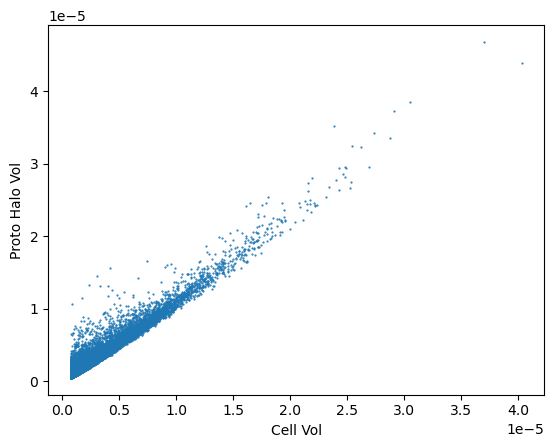

In [48]:
volumes = np.array(volumes)
plt.scatter(volumes[:,0], volumes[:,1] , s=0.3)
plt.ylabel('Proto Halo Vol')
plt.xlabel('Cell Vol')
plt.show()

In [52]:
volumes_data = {"Cell Volumes": volumes[:,0], "Proto Halo Volumes": volumes[:,1] }

df = pd.DataFrame(volumes_data)
df.to_csv("Volumes_data.csv")

## Inertia Eigenvalues Difference

## Proto Halo vs Halo

### Distance functions

In [27]:
def cos_similarity(eigsys1, eigsys2):
    # Compute the cosine similarity between two list of eigenvectors
    # cos_similarity = (vec1.vec2)/(||vec1|| ||vec2||)
    # Output.- sum of the elementwise application of cos_similarity of the two list
    #          of eigenvectors
    
    
    # Get the eigenvectors
    _, e_vec_1 = eigsys1
    _, e_vec_2 = eigsys2

    # Compute the sum of dot products
    dots = np.sum(e_vec_1*e_vec_2) 
    
    return dots


def lenght_diff(eigsys1, eigsys2):
    # Compute the lengthe difference between the eigenvectors
    
    # Get the eigenvalues
    e_val_1,_ = eigsys1
    e_val_2,_ = eigsys2

    # Compute the sum of dot products
    diff = np.sum(np.abs(e_val_2 - e_val_1 )) 
    
    return diff

def euc_dis(eigsys1, eigsys2):
    # Compute the euclidean distance between each corresponding eigenvector

    # Get the eigenvectors
    e_val_1, e_vec_1 = eigsys1
    e_val_2, e_vec_2 = eigsys2

    # Scale vectors
    e_vec_1 = (e_val_1*np.transpose(e_vec_1)).transpose()
    e_vec_2 = (e_val_2*np.transpose(e_vec_2)).transpose()

    # Euclidean distance vectorwise
    euc_dis = np.linalg.norm( e_vec_2 - e_vec_1, axis=1 )
    
    return np.sum(euc_dis)    
    

def transformation_dis(eigsys1, eigsys2):
    # Function that compute the transformation matrix A to pass from 
    # eigensystem 1 to eigensystem 2. Then, it computes the L2 norm of
    # the matrix A

    # Get the eigenvectors
    e_val_1, e_vec_1 = eigsys1
    e_val_2, e_vec_2 = eigsys2

    # Scale vectors
    e_vec_1 = (e_val_1*np.transpose(e_vec_1))
    e_vec_2 = (e_val_2*np.transpose(e_vec_2))

    # Construct matrices U and V using the given vectors
    U = e_vec_1
    V = e_vec_2

    # Calculate the matrix A using the formula A = V * U^(-1)
    U_inv = np.linalg.inv(U)
    A = np.dot(V, U_inv)

    # Compute L2 norm matrix A
    norm_A = np.linalg.norm(A, 2)

    return norm_A


def homogeneous_dis(eigsys1, eigsys2, center_1, center_2):
    # Function that compute the transformation matrix A to pass from 
    # eigensystem 1 to eigensystem 2 and also considers the displancement
    # using homogeneous coordinates. 
    # Then, it computes the L2 norm of the matrix A

    # Get the eigenvectors
    e_val_1, e_vec_1 = eigsys1
    e_val_2, e_vec_2 = eigsys2

    # Scale vectors
    e_vec_1 = (e_val_1*np.transpose(e_vec_1))
    e_vec_2 = (e_val_2*np.transpose(e_vec_2))

    # Construct matrices U and V using the given vectors
    U = e_vec_1
    V = e_vec_2

    # Calculate the matrix A using the formula A = V * U^(-1)
    U_inv = np.linalg.inv(U)
    A = np.dot(V, U_inv)

    # Here we extend matrix to
    # | a11 a12 a13 |
    # | a21 a22 a23 |
    # | a31 a32 a33 |
    # |  0   0   0  |
    A = np.vstack((A, [0,0,0]))

    # Get displacement
    d = center_2 - center_1
    d = np.hstack((d, [1]))

    # Add d as a column of A
    # | a11 a12 a13 d1|
    # | a21 a22 a23 d2|
    # | a31 a32 a33 d3|
    # |  0   0   0   1|
    
    d = d.reshape((4, 1))
    A = np.hstack((A, d))
    # Compute L2 norm matrix A
    norm_A = np.linalg.norm(A, 2)

    return norm_A

def distance_bary(center_1, center_2):    
    return np.linalg.norm(center_2 - center_1)

In [6]:
def visualize_axes(points, scale=4, colors = [[0.9, 0.0, 0], [0.5, 0.4, 0.0],[0., 0., 0.]]):
    # Compute the inertia tensor 
    I = inertia_tensor(points)

    # Compute barycenter
    center = barycenter(points)

    # Get eigen systems
    eig_v, eig_vec = np.linalg.eig(I)

    # Create lines per each vector

    val_0, val_1, val_2 = eig_v/scale
    axis_1 = vd.Line(center, center + val_0*eig_vec[0], c=colors[0])
    axis_2 = vd.Line(center, center + val_1*eig_vec[1], c=colors[1])
    axis_3 = vd.Line(center, center + val_2*eig_vec[2], c=colors[2])

    return axis_1, axis_2, axis_3
    

### Compute and store distances

In [9]:
# Init data frame
distances = {"Cos_similarity":[], 
            "Lenght_diff":[], 
            "Euc_dist":[], 
            "Transf_dist":[],
            "Hom_dist":[],
            "Distance_centers":[]
            }

# Loop over halos
for i in range(len(proto_halo)):

    # Get points proto halo and halo
    points_ph =  proto_halo[i]
    points_h  =  halo[i]

    # Get centers of mass of halos
    center_ph = barycenter(points_ph)
    center_h = barycenter(points_h)

    # Compute the inertia tensor 
    I_proto = inertia_tensor(points_ph)
    I_halo  = inertia_tensor(points_h)

    # Get eigen systems
    eigsystem_proto = np.linalg.eig(I_proto)
    eigsystem_halo  = np.linalg.eig(I_halo)

    # Compute corresponding distances and add them to the dictionary
    distances["Cos_similarity"].append(cos_similarity(eigsystem_proto, eigsystem_halo))
    distances["Lenght_diff"].append(lenght_diff(eigsystem_proto, eigsystem_halo))
    distances["Euc_dist"].append(euc_dis(eigsystem_proto, eigsystem_halo))
    distances["Transf_dist"].append(transformation_dis(eigsystem_proto, eigsystem_halo))
    distances["Hom_dist"].append(homogeneous_dis(eigsystem_proto, eigsystem_halo, center_ph, center_h))
    distances["Distance_centers"].append(distance_bary(center_ph, center_h))


# Create data frame
df = pd.DataFrame(distances)

### Export to csv

In [10]:
df.to_csv('distances_unscaled.csv')

       Cos_similarity   Lenght_diff      Euc_dist  Transf_dist  Hom_dist  \
0           -0.894927  3.156576e+06  3.218703e+06     0.020289  6.078121   
1            1.363597  3.177388e+06  3.211911e+06     0.044888  3.435506   
2           -0.939070  2.034615e+06  2.066876e+06     0.015963  5.212420   
3            2.670167  2.537082e+06  2.543595e+06     0.061726  7.695426   
4            0.540462  1.911826e+06  1.977746e+06     0.050398  9.239602   
...               ...           ...           ...          ...       ...   
66055        2.863841  5.337969e+03  5.340111e+03     0.014605  9.882243   
66056        2.830902  5.173147e+03  5.176684e+03     0.011835  9.052314   
66057       -0.982685  7.139637e+03  7.259046e+03     0.017531  9.942227   
66058        0.704210  4.215998e+03  4.268648e+03     0.019213  6.059308   
66059       -0.999544  6.881136e+03  6.963190e+03     0.012368  2.437775   

       Distance_centers  
0              5.995276  
1              3.286661  
2        

### Correlation between computed distances

In [25]:
correlation = df.corr()
print(correlation)

                  Cos_similarity  Lenght_diff  Euc_dist  Transf_dist  \
Cos_similarity          1.000000     0.003477  0.000491    -0.004672   
Lenght_diff             0.003477     1.000000  0.999904     0.055296   
Euc_dist                0.000491     0.999904  1.000000     0.058328   
Transf_dist            -0.004672     0.055296  0.058328     1.000000   
Hom_dist               -0.005303    -0.041641 -0.041642    -0.003730   
Distance_centers       -0.005309    -0.041591 -0.041592    -0.003707   

                  Hom_dist  Distance_centers  
Cos_similarity   -0.005303         -0.005309  
Lenght_diff      -0.041641         -0.041591  
Euc_dist         -0.041642         -0.041592  
Transf_dist      -0.003730         -0.003707  
Hom_dist          1.000000          0.999957  
Distance_centers  0.999957          1.000000  


/var/folders/x0/wnnm77vs13b4fdt3s73t9p19m3kpph/T/ipykernel_60913/311428597.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.columns, rotation=65, fontsize=15)
/var/folders/x0/wnnm77vs13b4fdt3s73t9p19m3kpph/T/ipykernel_60913/311428597.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df.columns, rotation=0, fontsize=15)


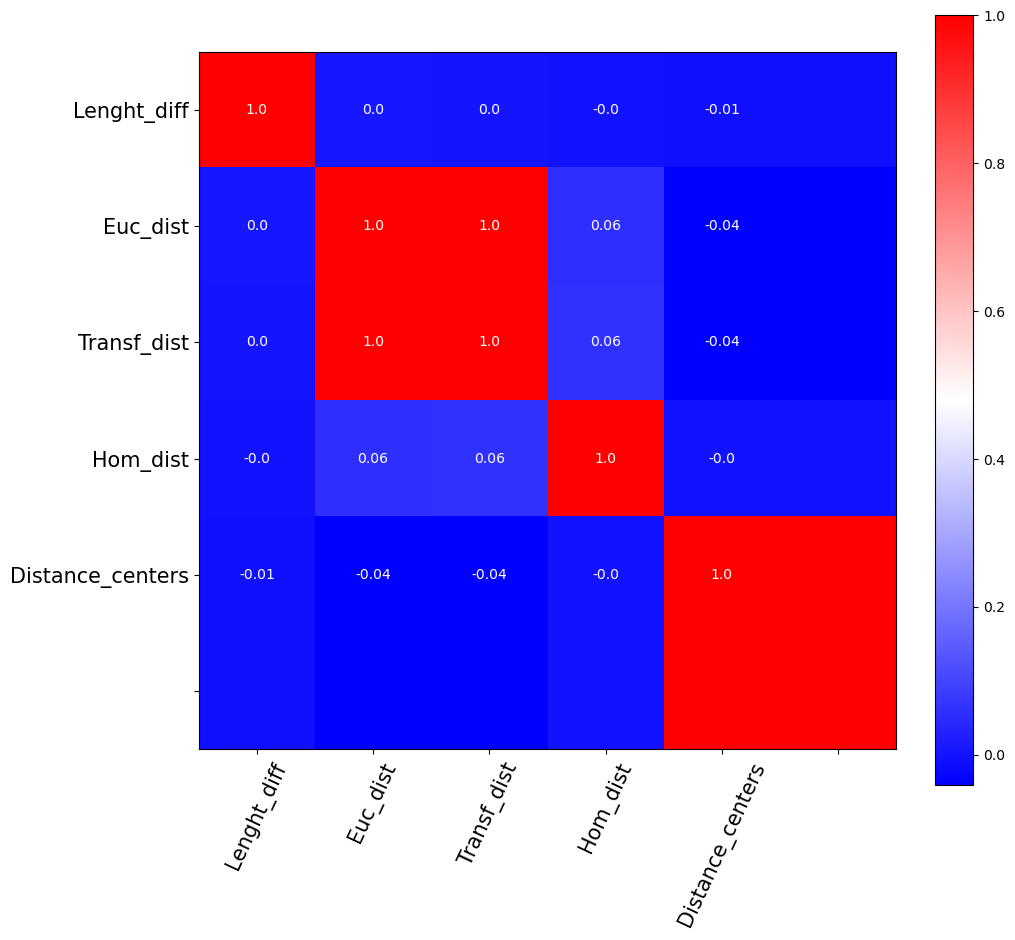

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(correlation, interpolation='nearest', cmap="bwr")
fig.colorbar(im, orientation='vertical', fraction = 0.05)

# Show all ticks and label them with the dataframe column name
ax.set_xticklabels(df.columns, rotation=65, fontsize=15)
ax.set_yticklabels(df.columns, rotation=0, fontsize=15)

# Loop over data dimensions and create text annotations
for i in range(len(df.columns)-1):
    for j in range(len(df.columns)-1):
        text = ax.text(j, i, round(correlation.to_numpy()[i, j], 2),
                       ha="center", va="center", color="white")

plt.show()

### Histograms of Each Distance function

array([[<Axes: title={'center': 'Cos_similarity'}>,
        <Axes: title={'center': 'Lenght_diff'}>],
       [<Axes: title={'center': 'Euc_dist'}>,
        <Axes: title={'center': 'Transf_dist'}>],
       [<Axes: title={'center': 'Hom_dist'}>,
        <Axes: title={'center': 'Distance_centers'}>]], dtype=object)

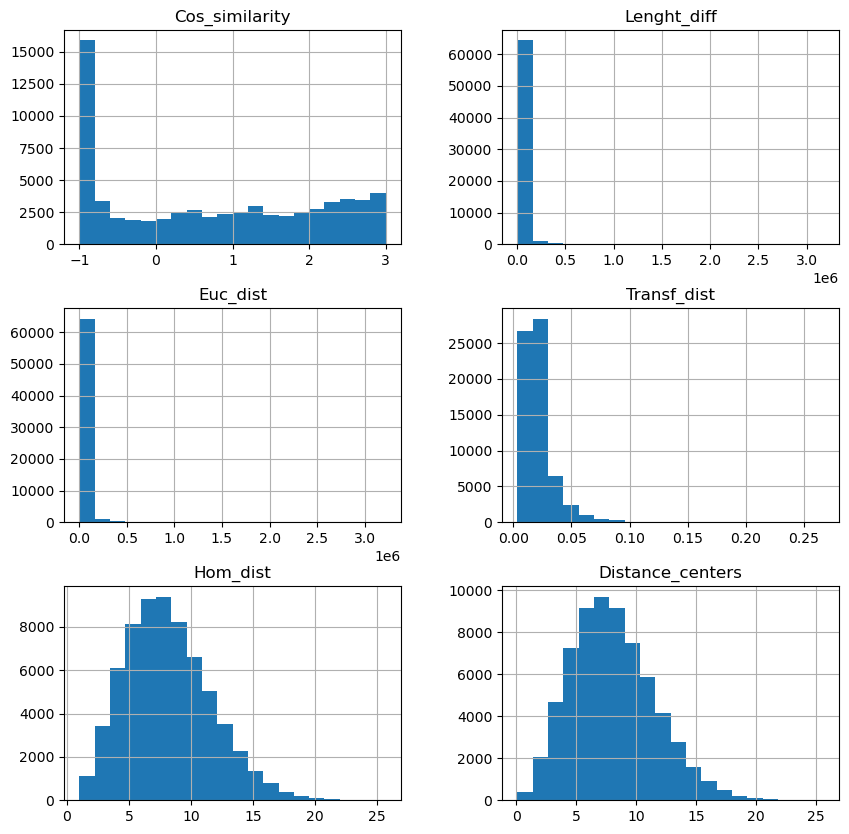

In [18]:
df.hist(bins=20, figsize= [10, 10])

## Visualization of data

In [13]:
max_row = df.loc[df['Hom_dist'].idxmax()]
# Define id of visualized proto halo and halo
id = max_row.name

# Get points into a point cloud for visualization
proto_vis = vd.Points(proto_halo[id], r=8, c = [0.9, 0.2, 0.1])
halo_vis  = vd.Points(halo[id], r=10, c = [0,0,0])
#cell = vd.Mesh((meshes[id][0], meshes[id][1]), alpha=0.4)

# Visualization of axes 
p_ax_1, p_ax_2, p_ax_3 = visualize_axes(proto_halo[id], scale=1)
h_ax_1, h_ax_2, h_ax_3 = visualize_axes(halo[id], scale =0.02)
# Print information
print(f"Mesh id: {max_row}")
print(f"Number of points: {len(proto_halo[id])}")

# Visualizaiton of halos with axes
#vd.show(proto_vis, halo_vis, p_ax_1, p_ax_2, p_ax_3 , h_ax_1, h_ax_2, h_ax_3)

# Visualizaiton of halos
vd.show(proto_vis, halo_vis)

Mesh id: Cos_similarity        2.675028
Lenght_diff       40186.895327
Euc_dist          40210.535408
Transf_dist           0.007416
Hom_dist             25.703078
Name: 19508, dtype: float64
Number of points: 237


Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], backgro…

In [37]:
proto_points = []

for k, pts in proto_halo.items():
    for pt in pts:
        proto_points.append(pt)

proto_points = np.array(proto_points)

In [38]:
halo_points = []

for k, pts in halo.items():
    for pt in pts:
        halo_points.append(pt)

halo_points = np.array(halo_points)

In [9]:
# Read obj raw
vertices, faces = read_obj_raw("/Users/cisneras/SGIAstro/local/HADES_1_gte100ptcl_cells.obj")

In [12]:
# t_proto_vis = vd.Points(proto_points[:], r =20, c = [0.9, 0.2, 0.1])
# t_halo_vis  = vd.Points(halo_points[:4000], r=10)

ps.init()

# visualize!
#ps_cloud = ps.register_point_cloud("Proto_Halo", proto_points)

# visualize!
ps_mesh = ps.register_surface_mesh("Obj_raw", np.array(vertices), faces)
ps.show()
ps_cloud = ps.register_point_cloud("Halo", halo_points, adius=0.01)
ps.show()

# # with some options
# ps_cloud_opt = ps.register_point_cloud("my points", points, 
#                                        radius=0.02, point_render_mode='quad')
# ps.show()

2023-08-11 00:16:06.684 python[44255:533902] GLDRendererMetal command buffer completion error: Error Domain=MTLCommandBufferErrorDomain Code=8 "Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)" UserInfo={NSLocalizedDescription=Insufficient Memory (00000008:kIOGPUCommandBufferCallbackErrorOutOfMemory)}


TypeError: register_point_cloud() got an unexpected keyword argument 'adius'